# Topographic grid generation and tectonics


In this notebook, we will see how to generate a regular topographic grid from a particular region that will have the desired format for running a badlands simulation.

Badlands imports a regular grid that is later triangularized and used to compute erosion and deposition induced by a combination of climate, tectonics and sea-level changes.

Here we use **ETOPO1** to create this initial grid. **ETOPO1** is a 1 arc-minute global relief model of Earth's surface that integrates land topography and ocean bathymetry. It was built from numerous global and regional data sets, and is available in "Ice Surface" (top of Antarctic and Greenland ice sheets) and "Bedrock" (base of the ice sheets) versions. 

In [7]:
import numpy as np
import pandas as pd
import matplotlib
import numpy.ma as ma
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.ndimage import gaussian_filter
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Import badlands grid generation toolbox
import badlands_companion.toolGrid as tools

# display plots in SVG format
%matplotlib inline
%config InlineBackend.figure_format = 'svg' 

# 1. Define region bounding box

We first need to provide the extent of the area we want to get the topography from. 

This is done by specifying the min/max longitudes and latitudes:
+ llcrnrlon: lower left corner longitude.
+ llcrnrlat: lower left corner latitude.
+ urcrnrlon: upper right corner longitude.
+ urcrnrlat: upper right corner latitude.

For more information regarding the function uncomment the following line.

In [8]:
#help(tools.toolGrid.__init__)

In [9]:
grid = tools.toolGrid(llcrnrlon = 156.5, llcrnrlat = 57.4, urcrnrlon = 162., urcrnrlat = 59.3)

# 2. Display region in Basemap 


Before extracting the topography for the desired region, we can first add an **ARCGIS** image of the area to **Basemap**. We retreive the image directly from *ArcGIS.com* web map servers. 

You can either use the EPSG [registry](https://www.epsg-registry.org) to get a specific code for your region of interest or you can use the default EPSG code provided in this notebook (EPSG::3857).

**EPSG::3857** is a projected CRS WGS 84/Pseudo-Mercator dataset which uses spherical development of ellipsoidal coordinates. The global data covers the world between 85.06°S and 85.06°N.

To visualise the Map using the EPSG code we use the `plotEPSG` function. For more information regarding the function uncomment the following cell.

In [10]:
#help(grid.plotEPSG)

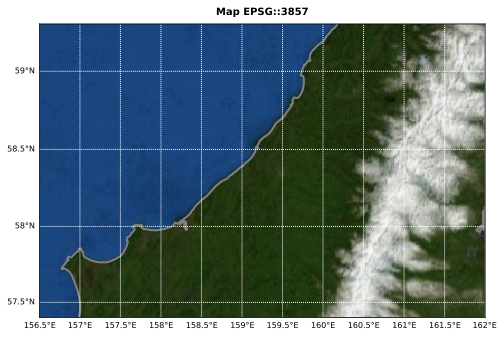

In [11]:
grid.plotEPSG( epsg=3857, llspace=0.5, fsize=(8,8), title = 'Map EPSG::3857' )

# 3. Extract dataset from etopo1

Instead of downloading the dataset on our local container, we use the NOAA THREDDS protocol to load the data from their server. The [dataset](http://www.ngdc.noaa.gov/thredds/dodsC/relief/ETOPO1/thredds/ETOPO1_Bed_g_gmt4.nc.html) is available in different format, here we choose to load the NETCDF file. Once the longitude and latitude for the entire grid has been loaded we only extract a subset (`getSubset` function) to download the values corresponding to the region of interest. 

The `getSubset` function  takes 3 parameters:
+ tfile: type of topographic / bathymetric file to load using THREDDS protocol (only etopo1 for now).
+ offset: offset to add to the grid to ensure the entire region of interest is still within the simulation area after reprojection in UTM coordinates.
+ smooth: use or not of a smoothing filter.

For more information regarding the function uncomment the following cell.

In [13]:
grid.getSubset(tfile = 'etopo1', offset = 0.1, smooth = False)

We know can use the `mapUTM` function to transform the dataset in **UTM** coordinates which is used to create Badlands grid. 

In addition the function creates a plot of the region based on exported **ETOPO1** dataset.

For more information regarding the function uncomment the following cell.

In [ ]:
#help(grid.mapUTM)

In [14]:
grid.mapUTM(contour=50, fsize=(8,8), saveFig=False, nameFig='map')

# 4. Export regular grid data

We now export a **CSV** regular grid that will be loaded in the simulation. The file provides for each line the following information:
+ X coordinates in meters (this axis has a West to East orientation),
+ Y coordinates in meters (this axis has a South to West orientation), 
+ Z coordinates in meters.

**Note:** Nodes must be defined in increasing order from the South/West corner, first along the X axis.


The `buildGrid` function takes the grid resolution from the **ETOPO1** dataset and interpolates it on a new grid which has a resolution specified by the *resolution* parameter (in metres). The function provides 3 types of interpolation methods (*'linear', 'nearest', 'cubic'*).

For more information regarding the function uncomment the following cell.

In [15]:
grid.buildGrid(resolution=2000., method='cubic', nameCSV='data/strat')

# 5. Changing elevation

Here we show how you can access the elevation file and apply some topographic modifications.

In [21]:
# Creating XY (horizontal) mesh
dx = 2000.
xgrid = np.arange(0,dx*grid.xi.shape[1],dx)
ygrid = np.arange(0,dx*grid.xi.shape[0],dx)
xi, yi = np.meshgrid(xgrid, ygrid)

# Reading elevation mesh
df = pd.read_csv("data/strat.csv",header=None, names=['X', 'Y', 'Z'],sep=r'\s+')
zmat = df.values[:,2].reshape(grid.xi.shape)

# Smoothing and rounding the elevation surface
zgauss = gaussian_filter(zmat, sigma=1)
zdec = np.around(zgauss, decimals=3)
nz = zgauss.reshape(grid.xi.shape)

# Writting the smoothed elevation grid on disk
df.to_csv('data/elev.csv',columns=['X', 'Y', 'Z'], sep=' ', index=False ,header=0)

Let us plot the new elevation

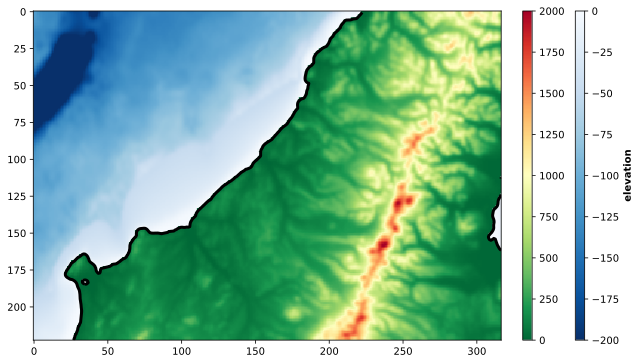

In [80]:
fig = plt.figure(figsize=(9, 7))

# make topo_mask a masked array, masking values lower than sea level.
topo_nz = np.where(nz < 0.,1.e10,nz)
topo_mask = ma.masked_values(topo_nz, 1.e10)

# make bathy_mask a masked array, masking values greater than sea level.
bathy_nz = np.where(nz >= 0.,1.e10,nz)
bathy_mask = ma.masked_values(bathy_nz, 1.e10)

palette = plt.cm.RdYlGn_r
palette2 = plt.cm.Blues_r
im = plt.imshow(np.flipud(topo_mask),palette,
                norm=colors.Normalize(vmin=0.0,vmax=2000.0,clip=False))
im2 = plt.imshow(np.flipud(bathy_mask),palette2,
                 norm=colors.Normalize(vmin=-200.0,vmax=0.0,clip=False))

ax = plt.gca()
ax.contour(nz, [0], colors='k', origin='image', linewidths=3)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.3)
cax2 = divider.append_axes("right", size="2%", pad=0.6)

cbar = plt.colorbar(im, cax=cax)
cbar2 = plt.colorbar(im2, cax=cax2)
cbar2.set_label('elevation',size=10,fontweight='bold')

fig.tight_layout()

# 5. Building a simple tectonic history 

Now we will create our own tectonic files. 

Here and for simplicity, we will use the topography to create the uplift/subsidence file called `upsub` in the cell below.

We apply some simple rules.

### First rule:

Building `upsub` array:
+ uplift on the land area: 100 m for elevation between sea-level and 400 m elevation.
+ uplift on the land area: 1000 m for elevation above 400 m elevation.
+ subsidence offshore: -1000 m for elevation between sea-level and -150 m depth.
+ subsidence offshore: -500 m for elevation below -150 m depth.


### Second rule:

Building `upsub_ld` array:
+ uplift on the land area: 100 m for elevation between sea-level and 200 m elevation.
+ uplift on the land area: 1800 m above 200 m elevation.


### Third rule:

Building `upsub_sea` array:
+ subsidence offshore: -1000 m for elevation between sea-level and -100 m depth.
+ subsidence offshore: -500 m for elevation between -100 m and -150 m depth.
+ subsidence offshore: -100 m for elevation below -150 m depth.

### Fourth rule:

Building loacal subsidence `locsub` in a specific area:

+ subsidence in the region located between [50:100,300:400]: -800 m for elevation below 100 m.

In [84]:
upsub = np.zeros(nz.shape)
upsub[nz>=0] = 100.
upsub[nz>=400] = 1000.
upsub[nz<0] = -1000.
upsub[nz<-150] = -500.

upsub_ld = np.zeros(nz.shape)
upsub_ld[nz>=0] = 100.
upsub_ld[nz>=200] = 1800.

upsub_sea = np.zeros(nz.shape)
upsub_sea[nz<0] = -1000.
upsub_sea[nz<-100] = -500.
upsub_sea[nz<-150] = -100.

locsub = np.zeros(nz.shape)
locsub[50:100,300:400] = -800.
locsub[nz>100] = 0.

We now apply a gaussian filter to smooth each of these tectonic grids and combine them together to create a unique tectonic field. 

In **badlands** the tectonic file contains the cumulative displacements and the rate will therefore be dependent on the simulation time provided in the XML input file.

In [82]:
gupsub_ld = gaussian_filter(upsub_ld, sigma=10)
gupsub_ld[upsub_ld<0] = 0.

gupsub_sea = gaussian_filter(upsub_sea, sigma=20)
gupsub_sea[gupsub_sea>0] = 0.

glocsub = gaussian_filter(locsub, sigma=10)
glocsub[glocsub>0] = 0.

glupsub = gupsub_ld+gupsub_sea+glocsub
gupsub = gaussian_filter(glupsub, sigma=1)*4.

The tectonic map looks like:

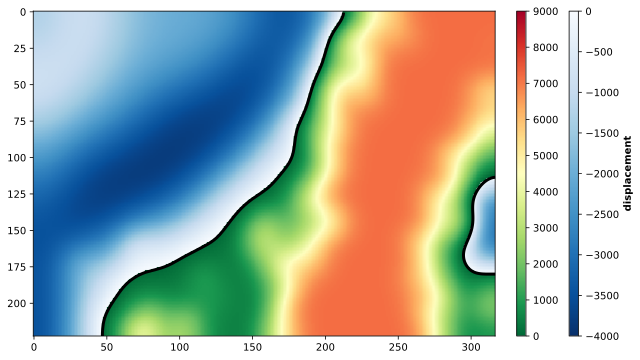

In [95]:
fig = plt.figure(figsize=(9, 7))

# make topo_mask a masked array, masking values lower than sea level.
topo_nz = np.where(gupsub < 0.,1.e10,gupsub)
topo_mask = ma.masked_values(topo_nz, 1.e10)

# make bathy_mask a masked array, masking values greater than sea level.
bathy_nz = np.where(gupsub >= 0.,1.e10,gupsub)
bathy_mask = ma.masked_values(bathy_nz, 1.e10)

palette = plt.cm.RdYlGn_r
palette2 = plt.cm.Blues_r
im = plt.imshow(np.flipud(topo_mask),palette,
                norm=colors.Normalize(vmin=0.0,vmax=9000.0,clip=False))
im2 = plt.imshow(np.flipud(bathy_mask),palette2,
                 norm=colors.Normalize(vmin=-4000.0,vmax=0.0,clip=False))

ax = plt.gca()
ax.contour(gupsub, [0], colors='k', origin='image', linewidths=3)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.3)
cax2 = divider.append_axes("right", size="2%", pad=0.6)

cbar = plt.colorbar(im, cax=cax)
cbar2 = plt.colorbar(im2, cax=cax2)
cbar2.set_label('displacement',size=10,fontweight='bold')

fig.tight_layout()

We now write this tectonic map on disk.

In [24]:
df = pd.DataFrame({'UpliftSubsidence':gupsub.flatten()})
df.to_csv('tectonic.csv',columns=['UpliftSubsidence'], sep=' ', index=False ,header=0)